In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import tensorflow.contrib.slim as slim
from models.ssl import group_l1_regularizer
keras = tf.contrib.keras
imp = keras.preprocessing.image

# Omniglot generator from matching net implementation

In [2]:
from datasets.omniglot import OmniglotNShotDataset

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
batch_size = 2
classes_per_set = 10
samples_per_class = 5
targets_per_class = 10

data = OmniglotNShotDataset(batch_size, classes_per_set, samples_per_class, targets_per_class, 
                            seed=2591, shuffle_classes=True)

train_shape (1200, 20, 28, 28, 1) test_shape (211, 20, 28, 28, 1) val_shape (211, 20, 28, 28, 1)


In [50]:
def gen():
    yield data.get_batch(dataset_name='train', augment='False')

ds = tf.data.Dataset()
ds = ds.from_generator(gen, 
                       ({'x_support': tf.float32,
                         'y_support': tf.int32,
                         'x_target': tf.float32},
                        tf.int32),)
#                       ({'x_support': (batch_size*classes_per_set*samples_per_class, 28,28,1),
#                          'y_support': (batch_size*classes_per_set*samples_per_class, 1, 1),
#                          'x_target': (batch_size*classes_per_set*targets_per_class, 28,28,1)},
#                         batch_size*classes_per_set*targets_per_class, 1, 1))
ds = ds.cache()
ds = ds.batch(batch_size=5)
data_iter = ds.make_one_shot_iterator()

def input_fn():
    return data_iter.get_next()
data_iter.output_types
data_iter.get_next()

({'x_support': <tf.Tensor 'IteratorGetNext_33:0' shape=<unknown> dtype=float32>,
  'x_target': <tf.Tensor 'IteratorGetNext_33:1' shape=<unknown> dtype=float32>,
  'y_support': <tf.Tensor 'IteratorGetNext_33:2' shape=<unknown> dtype=int32>},
 <tf.Tensor 'IteratorGetNext_33:3' shape=<unknown> dtype=int32>)

In [51]:
sess = tf.InteractiveSession()
features, labels = sess.run(data_iter.get_next())
features['x_target'].shape, labels.shape

((1, 200, 28, 28, 1), (1, 200, 1, 1))

In [4]:
def imshow_batch(features, labels):
    global batch_size, classes_per_set, samples_per_class, targets_per_class
    _,  h, w, _ = features['x_support'].shape
    x_support = np.reshape(features['x_support'], [batch_size, classes_per_set, samples_per_class, h, w, 1 ])
    x_target =  np.reshape(features['x_target'], [batch_size, classes_per_set, targets_per_class, h, w, 1 ])
    for b in range(batch_size):
        plt.figure()
        for i in range (classes_per_set):
            for j in range(samples_per_class):
                plt.subplot2grid((samples_per_class, classes_per_set), (j, i))
                img = x_support[b, i, j, :, : ,: ].squeeze()
                plt.imshow(img, cmap='Greys_r')
                plt.axis('off')
        plt.suptitle('batch %d support' % b)

    for b in range(batch_size):
        plt.figure()
        for i in range (classes_per_set):
            for j in range(targets_per_class):
                plt.subplot2grid((targets_per_class, classes_per_set), (j, i))
                img = x_target[b, i, j, :, : ,: ].squeeze()
                plt.imshow(img, cmap='Greys_r')
                plt.axis('off')
        plt.suptitle('batch %d target' % b)


(100, 28, 28, 1) (200, 28, 28, 1)


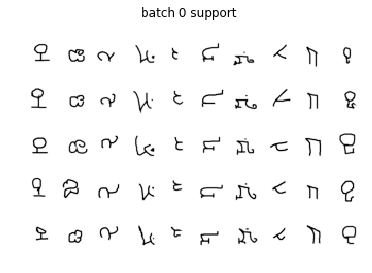

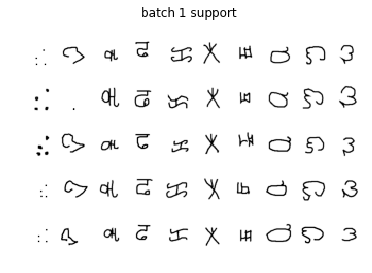

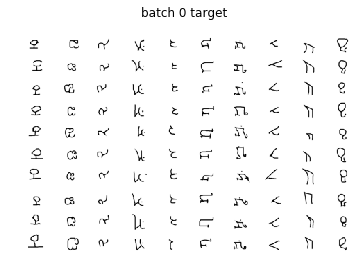

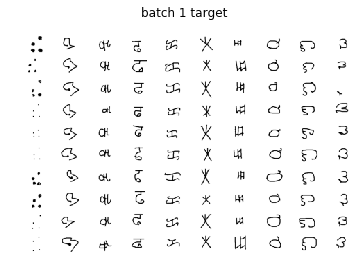

In [37]:
features, labels = data.get_train_batch(augment=True)
print(features['x_support'].shape, features['x_target'].shape)
imshow_batch(features, labels)

In [6]:
feat = data.sample_new_batch(data.datasets['train'])
print([f.shape for f in feat])

[(2, 10, 5, 28, 28, 1), (2, 10, 5), (2, 10, 10, 28, 28, 1), (2, 10, 10)]


# Save inception v3 features

In [99]:
# see omniglot_inceptionV3_features.py

In [358]:
from sklearn.decomposition import PCA
def plot2D(X, y):
    global N
    if X.shape[-1] > 2:
        pca = PCA(n_components=2)
        X_new = pca.fit_transform(X)
        print("explained variance ", pca.explained_variance_)
    else:
        X_new = X
    plt.figure()
    for k in range(N):
        points = np.ix_(y==k)
        plt.plot(X_new[points,0].squeeze(),X_new[points,1].squeeze(), label=str(k+1), 
                 marker='o', linestyle='', ms=8)
    plt.legend(loc='best')

explained variance  [ 0.82863921  0.47601423]


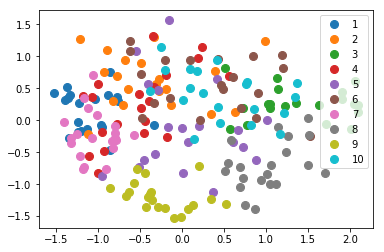

In [363]:
N = 10
features = np.load('./Data/omniglot_inceptionV3_features.npy')
n_classes, n_samples, n_features = features.shape
classes = np.random.choice(np.arange(features.shape[0]), size=N, replace=False)
X = np.reshape(features[classes, :, :], (N*n_samples, n_features))
y = np.repeat(np.arange(N), n_samples)
plot2D(X, y)